<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# [Ateliers: Technologies des grosses data](https://github.com/wikistat/Ateliers-Big-Data)

# [Reconnaissance d'images](https://github.com/wikistat/Ateliers-Big-Data/tree/master/CatsVSDogs):  [*cats vs. dogs*](https://www.kaggle.com/c/dogs-vs-cats/data)
# Tranfert d'apprentissage avec <a href="https://www.tensorflow.org/"><img src="https://avatars0.githubusercontent.com/u/15658638?s=200&v=4" width=100, style="display: inline" alt="TensorFlow"/></a> tensorflow et  <a href="https://keras.io/"><img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" width=250, style="display: inline" alt="Keras"/></a>

### Résumé
Apprentissage d'un réseau convolutionnel élémentaire puis utilisation de réseaux pré-entrainés (`VGG16`, `InceptionV3`) sur la base [ImageNet](http://www.image-net.org/) afin de résoudre un autre exemple de reconnaissance d'images. Utilisation de [Keras](https://keras.io/) pour piloter la librairie [tensorFlow](https://www.tensorflow.org/). Comparaison des performances des réseaux et des environnements de calcul CPU et GPU.

## 1 Introduction
### 1.1 Objectifs
La reconnaissance d'images a franchi une étape majeure en 2012. L'empilement de couches de neurones, dont certaines convolutionnelles, ont conduit à des algorithmes nettement plus performants en reconnaissance d'image, traitement du langage naturel, et à l'origine d'un battage médiatique considérable autour de l'apprentissage épais ou *deep learning*. Néanmoins, apprendre un réseau profond comportant des milions de paramètres nécessite une base d'apprentissage excessivement volumineuse (*e.g.* [ImageNet](http://www.image-net.org/)) avec des millions d'images labellisées. 

L'apprentissage s'avère donc très couteux en temps de calcul, même avec des technologies adaptées (GPU). Pour résoudre ce problème il est possible d'utiliser des réseaux *pré-entrainés*. Ces réseaux possèdent une structure particulière, établie de façon heuristique dans différents départements de recherche (Microsoft: Resnet, Google: Inception V3, Facebook: ResNet) avant d'être ajustés sur des banques d'images publiques telles que [ImageNet](http://www.image-net.org/). 

La stratégie de ce  *transfert d'apprentissage* consiste à exploiter la connaissance acquise sur un problème de classification général pour l’appliquer à un problème particulier.

La librairie [Keras](https://keras.io/) permet de construire de tels réseaux en utlisant relativement simplement l'environnement  [tensorFlow](https://www.tensorflow.org/) de Google à partir de programmes récrits en Python. De plus Keras permet d'utiliser les performances d'une carte GPU afin d'atteindre des performances endant possible ce transfert d'apprentissage, même avec des réseaux complexes.

L'objectif de ce tutoriel est de montrer les capacités du *transfert d'apprentissage* permettant de résoudre des problèmes complexes avec des moyens de calcul modestes. Néanmoins, une carte GPU est vivement conseillé.

Ce tutoriel est en grande partie inspiré du [blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) de François Chollet à l'initiative de [Keras](https://keras.io/).

### 1.2 Environnement matériel et logiciel
Keras et tensorFlow s'installent simplement à partir de la distribution Anaconda de Python. 

In [1]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Visualisaiton des données
from matplotlib import pyplot as plt


# fix seed for reproducible results (only works on CPU, not GPU)
seed = 42
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)


La commande suivante permet de verifier qu'une carte GPU est bien disponible sur la machine utilisée. Si c'est le cas et si Keras a bien été installé dans la configuration GPU (c'est généralement le cas dans l'environement virtuel GPU d'Anaconda), deux options vont apparaitre, une CPU et une GPU. La configuration GPU sera alors automatiquement utilisée.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10041937600071842403
]


In [3]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

CPU


## 2 Prise en charge des données 

### 2.1 Structure des données 

Les données originales peuvent être téléchargées à partir du site [kaggle](https://www.kaggle.com/c/dogs-vs-cats/data).
L'ensemble d'apprentissage contient 25.000 images. C'est beaucoup trop pour des machines usuelles à moins de se montrer très patient.  Aussi, deux sous-échantillons d'apprentissage ont été créés et disposés dans le dépôt.

1. 100 images de chats et 100 images de chiens plus un échantillon de validation consitué de 40 images de chats et 40 images de chien. 
2. 1000 images de chats et 1000 images de chiens plus un échantillon de validation consitué de 400 images de chats et 400 images de chien.

Pour utiliser certaines fonctionnalités de Keras, les données doivent être organisées selon une abrorescence précise. Les fichiers appartenant à une même classe doivent être dans un même dossier. 

```
data_dir
└───subsample/
│   └───train/
│   │   └───cats/
│   │   │   │   cat.0.jpg
│   │   │   │   cat.1.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.0.jpg
│   │   │   │   dog.1.jpg
│   │   │   │   ...
│   └───test/
│   │   └───cats/
│   │   │   │   cat.1000.jpg
│   │   │   │   cat.1000.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.1000.jpg
│   │   │   │   dog.1000.jpg
│   │   │   │   ...
```

*N.B.* Des sous-échantillons plus importants créés à partir des données originales doivent être enregistrés en respectant scrupuleusement cette structure.

### 2.2 Création d'un jeu d'apprentissage et de validation
Spécifier le chemin du dossier contenant les données, si ce n'est pas le répertoire courant, ainsi que les tailles des échantillons d'apprentissage et de validation.

In [4]:
data_dir = '/Users/bguillouet/Insa/DeepLearning/data/cats_and_dogs/' # chemin d'accès aux données

N_train = 200
N_val = 80

data_dir_sub = data_dir+'subsample_%dN_train_%d_N_val' %(N_train, N_val)

### 2.3  Illustration des données

La fonction `load_img` permet de charger une image comme une image PIL.

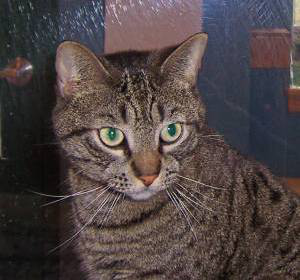

In [5]:
img = kpi.load_img(data_dir_sub+'/train/cats/cat.1.jpg')  # this is a PIL image
img

La fonction `img_to_array` génére un `array numpy` a partir d'une image PIL .

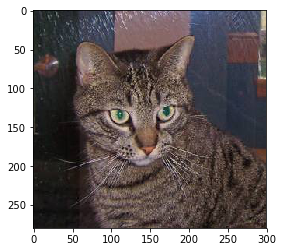

In [6]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

### 2.4 Pré-traitements

Les images du jeu de données sont de dimensions différentes : 

In [7]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.0.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg"))
x_0.shape, x_1.shape

((374, 500, 3), (280, 300, 3))

La fonction `ImageDataGenerator`de `Keras` permet de remédier à ce problème.

Plus généralement cette fonction applique un certain nombre de traitements (transformation, normalisation) aléatoires sur les images de sorte que le modèle n'apprenne jamais deux fois la même image.

Quelques arguments de cette fonction:
* `rotation_range`: Un interval représentant les degrés possibles de rotation de l'image,
* `width_shift` and `height_shift`: intervales au sein desquels les données peuvent être translatées horizontalement ou verticalement, 
* `rescale`:  Une valeur par lequelle les données sont multipliées,
* `shear_range`:  Transvection,
* `zoom_range`: Permet des zoom au sein d'une image,
* `horizontal_flip`: Inverse aléatoirement des images selon l'axe horizontal,
* `fill_mode`: La strategie adoptée pour combler les pixels manquants après une transformation.

### 2.5 Chargement des données

In [8]:
datagen = kpi.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Illustration des tranformations sur un exemple.

In [9]:
img_width = 150
img_height = 150

img = kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg")  # this is a PIL image
x = kpi.img_to_array(img)  
x_ = x.reshape((1,) + x.shape)

if not(os.path.isdir(data_dir_sub+"/preprocessing_example")):
    os.mkdir(data_dir_sub+"/preprocessing_example")

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir_sub+"/preprocessing_example", save_prefix='cat', save_format='jpeg'):
        i += 1
        if i > 7:
            break  

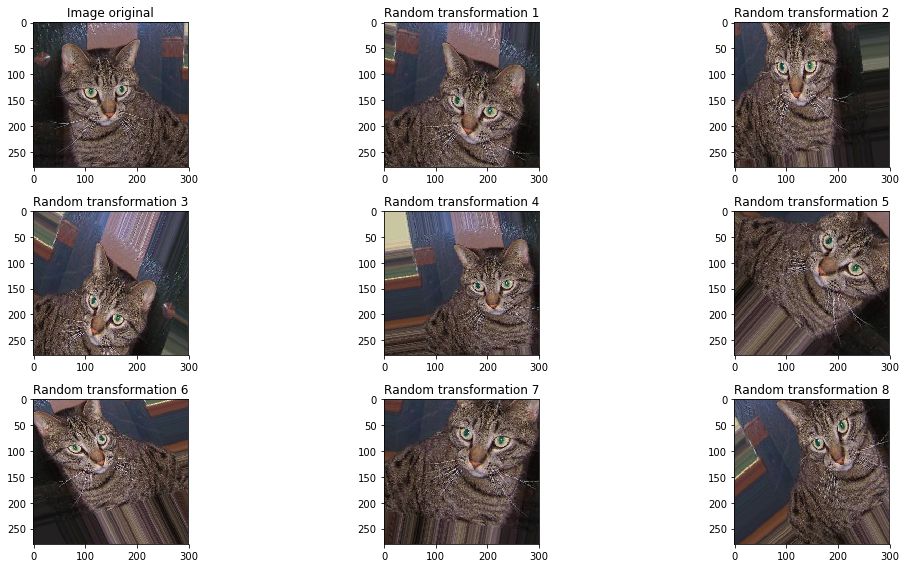

In [10]:
X_list=[]
for f in os.listdir(data_dir_sub+"/preprocessing_example"):
    X_list.append(kpi.img_to_array(kpi.load_img(data_dir_sub+"/preprocessing_example/"+f)))


fig=plt.figure(figsize=(16,8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3,3,1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i,xt in enumerate(X_list):
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" %(i+1))
plt.tight_layout()
plt.savefig("cats_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

## 3 Classification d'image à l'aide du Deep Learning

Dans un premier temps, nous allons fixer le nombre d'epochs ainsi que la taille de notre batch afin que ces deux paramètres soit communs aux différentes méthodes que nous allons tester. 
Queques règles à suivre pour le choix de ces paramètres :

* `epochs`: Commencer avec un nombre d'epochs relativement faible (2,3) afin de voir le temps de calcul nécessaire à votre machine, puis augmenter le en conséquence.
* `batch_size`: La taille du batch correspond au nombre d'éléments qui seront étudié a chaque itération au cours d'une epochs. 
**Important** : Avec Keras, la taille du batch doit être un diviseur de la taille de l'échantillon. Sinon l'algorithme aura des comportement anormaux qui ne généreront pas forcément un message d'erreur.


In [11]:
epochs = 3
batch_size=20

### 3.1Réseau convolutionnel

Dans un premiers temps, on construit notre propre réseau de neurones convolutionnel.

#### Génération des données

On définit deux objets `ImageDataGenerator` :

* `train_datagen`: pour l'apprentissage, où différentes transformations sont appliquées, comme précédement
* `valid_datagen`: pour la validation, où l'on applique seulement une transformation *rescale* pour ne pas déformer les données.

Il est également important de définir la taille des images dans laquelle nos images seront reformatées. Ici nous choisirons un taille d'image de 150x150

In [12]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir_sub+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir_sub+"/validation/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 200 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


#### Définition du modèle

Le modèle est consitué de 3 blocs de convolution consitutés chacun de:

* Une couche de `Convolution2D`
* Une couche d'`Activation` ReLU
* Une couche `MaxPooling2D`

Suivi de :
* Une couche `Flatten`, permettant de convertir les features de 2 à 1 dimensions. 
* Une couche `Dense` (Fully connected layer)
* Une couche d' `Activation` ReLU
* Une couche `Dropout`
* Une couche `Dense` de taille 1 suivi d'une `Activation` sigmoid permettant la classification binaire

On utilise la fonction de perte `binary_crossentropy` pour apprendre notre modèle


In [13]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

#### Apprentissage

In [14]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs,
       validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning TIme for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))
model_conv.save(data_dir_sub+'/'+MODE+'_models_convolutional_network_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

Epoch 1/3
10/10 [==============================] - 9s - loss: 0.7625 - acc: 0.4900 - val_loss: 0.7047 - val_acc: 0.5000
Epoch 2/3
10/10 [==============================] - 7s - loss: 0.6941 - acc: 0.5050 - val_loss: 0.6948 - val_acc: 0.5000
Epoch 3/3
10/10 [==============================] - 7s - loss: 0.6975 - acc: 0.5600 - val_loss: 0.7623 - val_acc: 0.4375
Learning TIme for 3 epochs : 28 seconds


#### Prédiction

In [15]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val //batch_size)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train// batch_size)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Test accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

Train accuracy: 0.47500000298
Test accuracy: 0.499999992549
Time Prediction: 5.80 seconds


#### Sauver le modèle et les metadata

In [16]:
metadata_conv = {"score_val" : score_conv_val, "score_train" : score_conv_train,
                 "t_learning" : t_learning_conv_simple_model, "t_prediction" : t_prediction_conv_simple_model}
pickle.dump(metadata_conv, open(data_dir_sub+'/'+MODE+'_metadata_convolutional_network_%d_epochs_%d_batch_size.pkl' %(epochs, batch_size), "wb"))


### 3.2 Réseau pré-entrainé : VGG16

Nous allons voir dans cette partie deux façon d'utiliser un modèle pré-entrainé:

1. Dans un premier temps on utilise le modèle pour extraire des features des images. Ces features sont le résultats des transformations des différents blocs de convolution sur nos images.  
2. Dans un second temps on utilisera le modèle comme une initialisation du modèle, qui est ensuite ré-entraîné plus finement (Fine Tuning) sur le dernier bloc de convolution pour traiter le nouveau problème de classification.


#### Illustration du réseau

![](https://blog.keras.io/img/imgclf/vgg16_original.png)

#### Extraction de nouvelle caractéristiques (*features*)

##### Téléchargement des poids du modèle

Si cest la première fois que vous appeler l'application `VGG16`, le lancement des poids commencera automatiquement et seront stocké dans votre home : `"~/.keras/models"`

On utilise le modèle avec l'option `ìnclude_top` = False. C'est à dire que l'on ne télécharge pas le dernier bloc `Fully connected` classifier. 

La fonction `summary` permet de retrouver la structure décrite précédemment.

In [17]:
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet')
model_VGG16_without_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

##### Création des caractéristiques

On applique alors les 5 blocs du modèle VGG16 sur les images de nos échantillons d'apprentissage et de validation.

Cette opération peut-être couteuse, c'est pourquoi on va sauver ces features dans des fichiers.
Si ces fichiers existent, les poids seront téléchargés, sinon il seront créés.

In [18]:
features_train_path = data_dir_sub+'/'+MODE+'_features_train_%d_epochs_%d_batch_size.npy' %(epochs, batch_size)
features_validation_path = data_dir_sub+'/'+MODE+'_features_validation_%d_epochs_%d_batch_size.npy' %(epochs, batch_size)

if os.path.isfile(features_train_path) and os.path.isfile(features_validation_path):
    print("Load Features")
    features_train = np.load(open(features_train_path, "rb"))
    features_validation = np.load(open(features_validation_path, "rb"))
    
else:
    print("Generate Features")
    datagen = kpi.ImageDataGenerator(rescale=1. / 255)


    ts = time.time()
    generator = datagen.flow_from_directory(
            data_dir_sub+"/train",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,  # this means our generator will only yield batches of data, no labels
            shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
    # the predict_generator method returns the output of a model, given
    # a generator that yields batches of numpy data
    features_train = model_VGG16_without_top.predict_generator(generator, N_train // batch_size,  verbose = 1)
    # save the output as a Numpy array
    np.save(open(features_train_path, 'wb'), features_train)
    te=time.time()
    t_features_train = te-ts
    ts = time.time()

    generator = datagen.flow_from_directory(
        data_dir_sub+"/validation",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
    features_validation = model_VGG16_without_top.predict_generator(generator, N_val //batch_size,  verbose = 1)


    np.save(open(features_validation_path, 'wb'), features_validation)
    te=time.time()
    t_features_validation = te-ts
    
    pickle.dump([t_features_train, t_features_validation], open(data_dir_sub+'/'+MODE+'_time_features_train_%d_epochs_%d_batch_size.npy' %(epochs,batch_size), "wb"))




Load Features


##### Construction d'un réseaux de neurone classique.

On construit un réseaux de neurones "classique", identique à la seconde partie du réseau précédent. 

*Attention* : La première couche de ce réseaux (`Flatten`) doit être configurée pour prendre en compte des données dans la dimension des features générées précédemment

In [19]:
features_train.shape

(200, 4, 4, 512)

In [20]:
model_VGG_fcm = km.Sequential()
model_VGG_fcm.add(kl.Flatten(input_shape=features_train.shape[1:]))
model_VGG_fcm.add(kl.Dense(64, activation='relu'))
model_VGG_fcm.add(kl.Dropout(0.5))
model_VGG_fcm.add(kl.Dense(1, activation='sigmoid'))

model_VGG_fcm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_VGG_fcm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 524,417
Trainable params: 524,417
Non-trainable params: 0
_________________________________________________________________


##### Apprentissage

In [21]:
ts=time.time()

# On créer des vecteurs labels

train_labels = np.array([0] * int((N_train/2)) + [1] * int((N_train/2)))
validation_labels = np.array([0] * int((N_val/2)) + [1] * int((N_val/2)))

model_VGG_fcm.fit(features_train, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(features_validation, validation_labels))
te = time.time()
t_learning_VGG_fcm = te-ts
model_VGG_fcm.save(data_dir_sub+'/'+MODE+'_models_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

Train on 200 samples, validate on 80 samples
Epoch 1/3
200/200 [==============================] - 0s - loss: 0.9984 - acc: 0.6200 - val_loss: 0.4055 - val_acc: 0.8750
Epoch 2/3
200/200 [==============================] - 0s - loss: 0.5821 - acc: 0.6900 - val_loss: 0.3135 - val_acc: 0.9000
Epoch 3/3
200/200 [==============================] - 0s - loss: 0.3731 - acc: 0.8450 - val_loss: 0.5663 - val_acc: 0.6875


Nous allons également sauver les poids de ce modèle afin de les réusiliser dans la prochaine partie.

In [22]:
model_VGG_fcm.save_weights(data_dir_sub+'/'+MODE+'_weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

##### Prédiction

In [23]:
ts = time.time()
score_VGG_fcm_val = model_VGG_fcm.evaluate(features_validation, validation_labels)
score_VGG_fcm_train = model_VGG_fcm.evaluate(features_train, train_labels)
te = time.time()
t_prediction_VGG_fcm = te-ts
print('Train accuracy:', score_VGG_fcm_val[1])
print('Test accuracy:', score_VGG_fcm_train[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_fcm)

 32/200 [===>..........................] - ETA: 0sTrain accuracy: 0.6875
Test accuracy: 0.795
Time Prediction: 0.05 seconds


#### Save metadata

In [24]:
metadata_VGG_fcm = {"score_val" : score_VGG_fcm_val, "score_train" : score_VGG_fcm_train, 
                    "t_learning" : t_learning_VGG_fcm, "t_prediction" : t_prediction_VGG_fcm}
pickle.dump(metadata_VGG_fcm, open(data_dir_sub+'/'+MODE+'_metadata_VGG_fully_connected_model_%d_epochs_%d_batch_size.pkl' %(epochs, batch_size), "wb"))


### 3.3 Ajustement fin du réseau VGG16

Dans la partie précédente, nous avons configurer un bloc de réseaux de neurones, à même de prendre en entrée les features issues des transformation des 5 premiers blocs de convolution du modèle VGG16. 

Dans cette partie, nous allons 'brancher' ce bloc directement sur les cinq premiers blocs du modèle VGG16 pour pouvoir affiner le modèle en itérant a la fois sur les blocs de convolution mais également sur notre bloc de réseau de neurone.

![](https://blog.keras.io/img/imgclf/vgg16_modified.png)

#### Description du modèle

On télécharge dans un premier temps le modèle VGG16, comme précédement. 
Cependant, le modèle va cette fois être "entrainé" directement, et ne va pas servir qu'a générer des features, il faut donc préciser en paramètre la taille des images que l'on va lui donner.

In [25]:
# build the VGG16 network
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))
print('Model loaded.')

Model loaded.


On ajoute au modèle VGG, notre bloc de réseaux de neuronne construit précédemment. 
Pour cela, on construit le bloc comme précédemment, puis on y ajoute les poids issus de l'apprentissage également réasilsé précédemment

In [26]:
# build a classifier model to put on top of the convolutional model
top_model = km.Sequential()
top_model.add(kl.Flatten(input_shape=model_VGG16_without_top.output_shape[1:]))
top_model.add(kl.Dense(64, activation='relu'))
top_model.add(kl.Dropout(0.5))
top_model.add(kl.Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

top_model.load_weights(data_dir_sub+'/'+MODE+'_weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))


Puis on concatane les deux parties du modèles

In [27]:
# add the model on top of the convolutional base
model_VGG_LastConv_fcm = km.Model(inputs=model_VGG16_without_top.input, outputs=top_model(model_VGG16_without_top.output))

model_VGG_LastConv_fcm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

##### Gèle des 4 premiers blocs de convolution

En pratique, et pour pouvoir effectuer ces calculs dans un temps raisonable, nous allons "fine-tuner" seulement le dernier bloc de convolution du modèle, le bloc 5 (couches 16 à 19 dans le summary du modèle précédent) ainsi que le bloc de réseau de neurones que nous avons ajoutés. 

Pour cela on va "geler" (Freeze) les 15 premières couches du modèle pour que leur paramètre ne soit pas optimiser pendant la phase d'apprentissage.

In [28]:
# set the first 25 layers (up to the last conv bloc)
# to non-trainable (weights will not be updated)
for layer in model_VGG_LastConv_fcm.layers[:15]:
    layer.trainable = False
    
    
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model_VGG_LastConv_fcm.compile(loss='binary_crossentropy',
              optimizer=ko.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


##### Generate Data

In [29]:
# prepare data augmentation configuration
train_datagen = kpi.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    data_dir_sub+"/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    data_dir_sub+"/validation/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


Found 200 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


##### Apprentissage

In [30]:
# fine-tune the model
ts = time.time()
model_VGG_LastConv_fcm.fit_generator(
    train_generator,
    steps_per_epoch=N_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=N_val // batch_size)
te = time.time()
t_learning_VGG_LastConv_fcm = te-ts


Epoch 1/3
10/10 [==============================] - 118s - loss: 0.4541 - acc: 0.7900 - val_loss: 0.2996 - val_acc: 0.9000
Epoch 2/3
10/10 [==============================] - 112s - loss: 0.3571 - acc: 0.8350 - val_loss: 0.3477 - val_acc: 0.8500
Epoch 3/3
10/10 [==============================] - 106s - loss: 0.4258 - acc: 0.7950 - val_loss: 0.3020 - val_acc: 0.9000


#####  Prédiction

In [31]:
ts = time.time()
score_VGG_LastConv_fcm_val = model_VGG_LastConv_fcm.evaluate_generator(validation_generator, N_val // batch_size)
score_VGG_LastConv_fcm_train = model_VGG_LastConv_fcm.evaluate_generator(train_generator, N_train // batch_size)

te = time.time()
t_prediction_VGG_LastConv_fcm = te-ts
print('Train accuracy:', score_VGG_LastConv_fcm_val[1])
print('Test accuracy:', score_VGG_LastConv_fcm_train[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_LastConv_fcm)

Train accuracy: 0.899999991059
Test accuracy: 0.919999992847
Time Prediction: 98.58 seconds


#####  Save Metadata

In [32]:
metadata_VGG_LastConv_fcm = {"score_val" : score_VGG_LastConv_fcm_val, "score_train" : score_VGG_LastConv_fcm_train, 
                             "t_learning" : t_learning_VGG_LastConv_fcm, "t_prediction" : t_prediction_VGG_LastConv_fcm}
pickle.dump(metadata_VGG_LastConv_fcm, open(data_dir_sub+'/'+MODE+'_metadata_VGG_LastConv_fully_connected_model_%d_epochs_%d_batch_size.pkl' %(epochs, batch_size), "wb"))


###  Autres modèles

Keras possède un certain nombre d'autres modèles pré-entrainés:

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet

Certains possèdent une structure bien plus complexe, notamment `InceptionV3`. Vous pouvez très facilement remplacer la fonction `ka.VGG16` par une autre fonction (ex : `ka.InceptionV3`) pour tester la performance des ces différents modèles et leur complexité.